In [1]:

import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op

In [2]:
ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")
OUT_DIR.mkdir(parents=True, exist_ok=True)


Processing S01E01


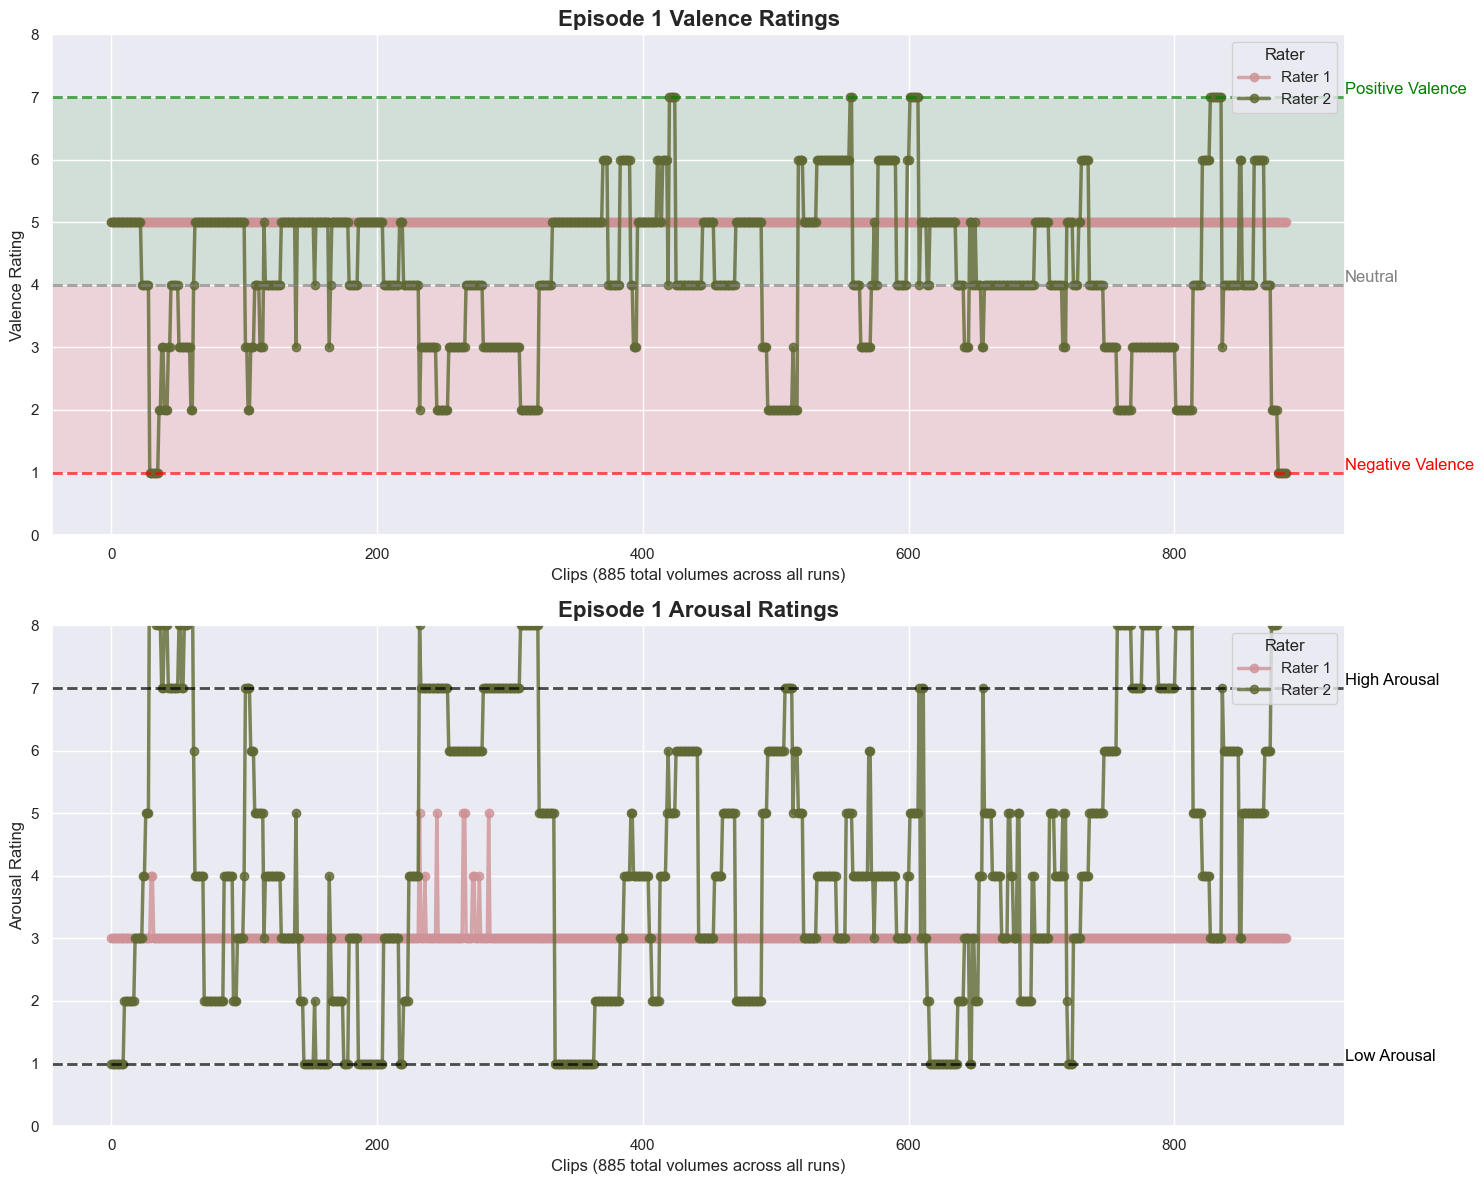

Sequential position range: 0 - 884
Total clips: 885
Number of runs: 3

Processing S01E02


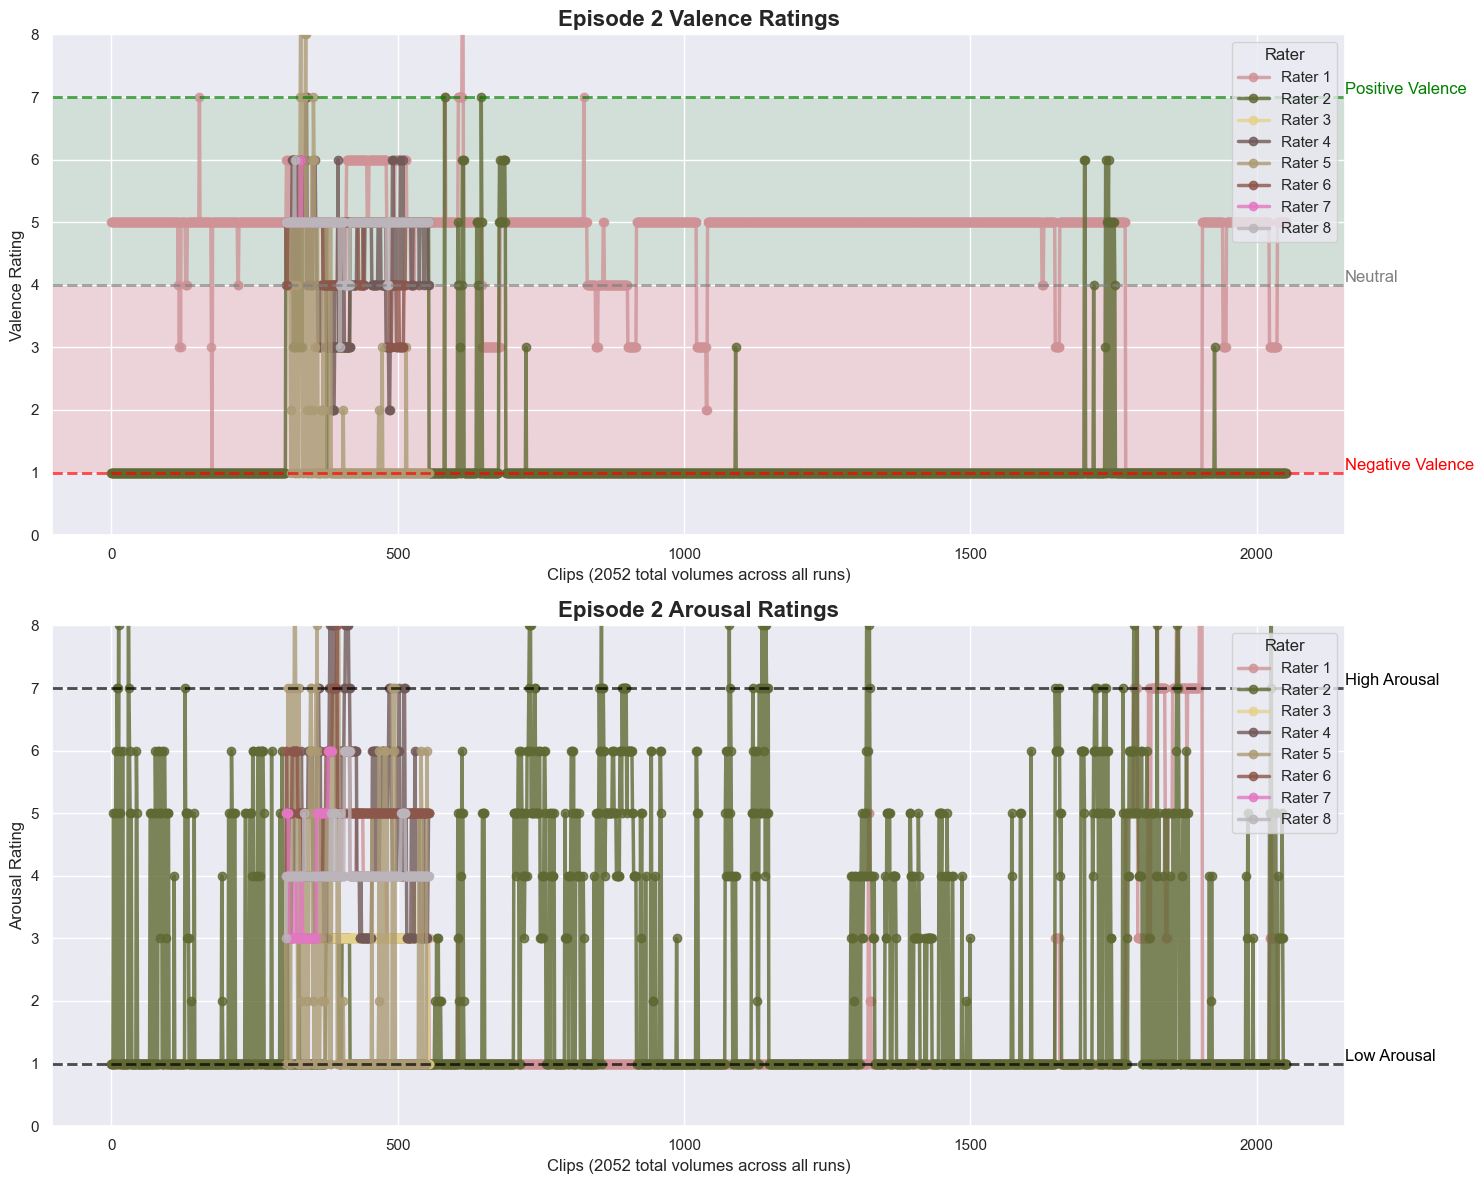

Sequential position range: 0 - 2051
Total clips: 2052
Number of runs: 7

Processing S01E03


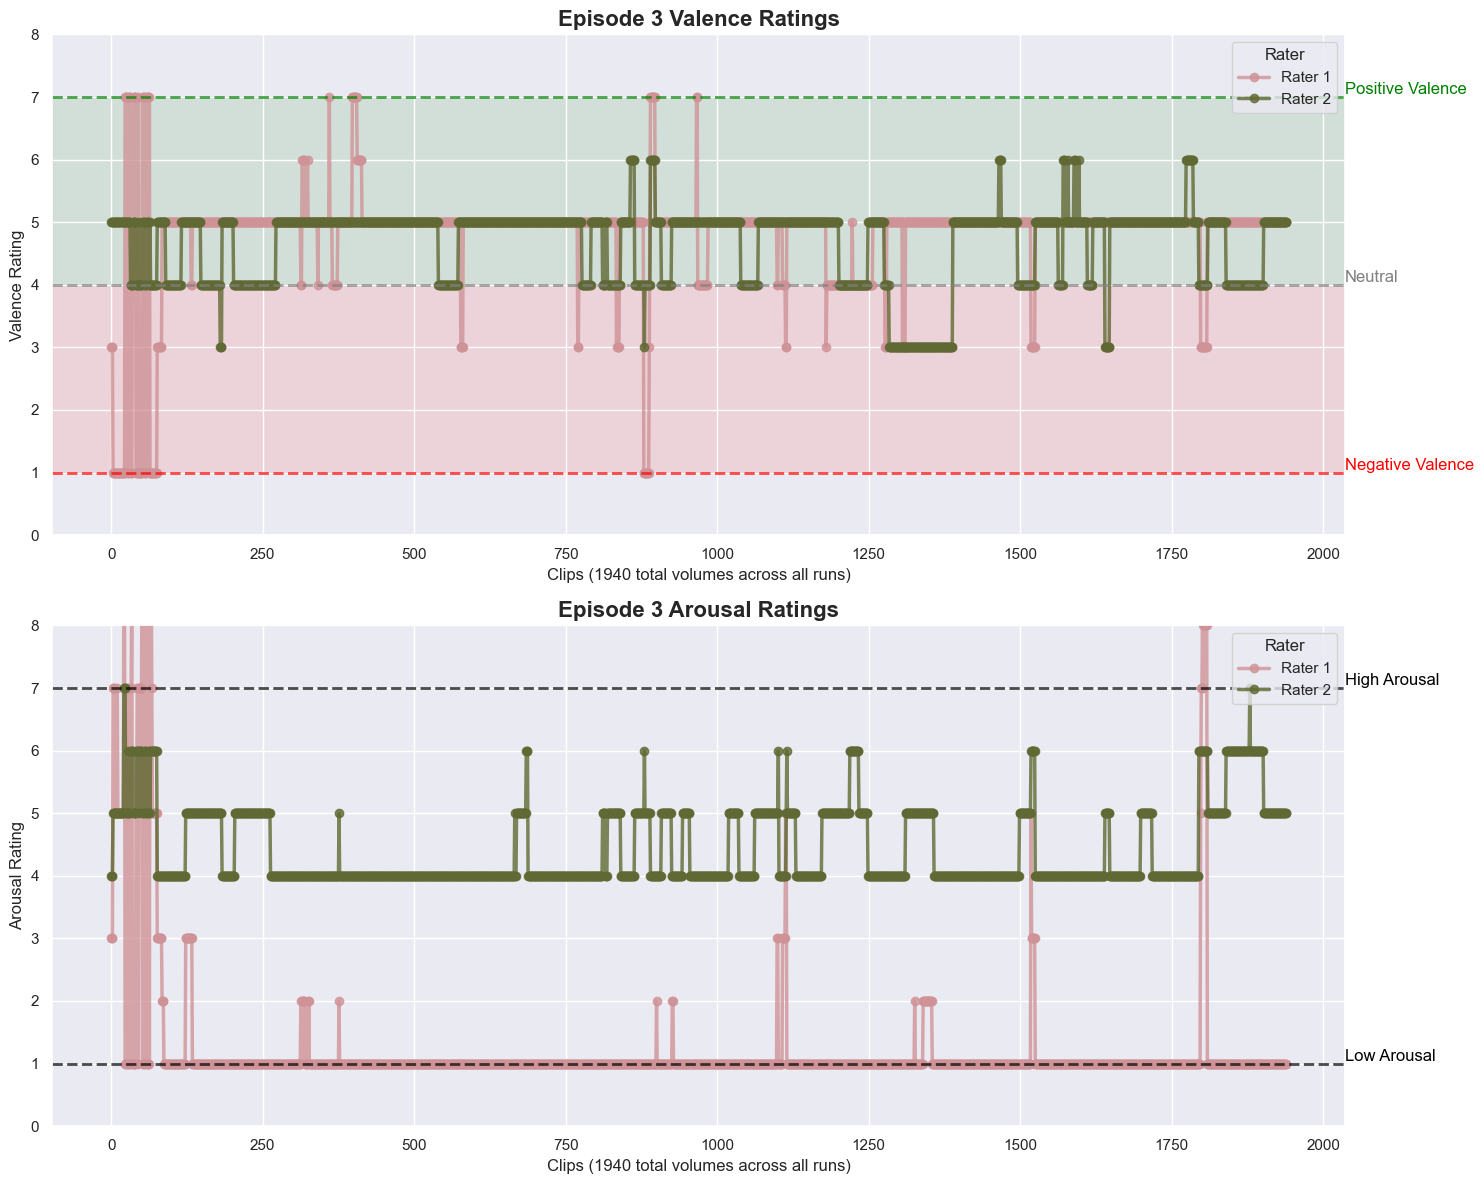

Sequential position range: 0 - 1939
Total clips: 1940
Number of runs: 6

Processing S01E04


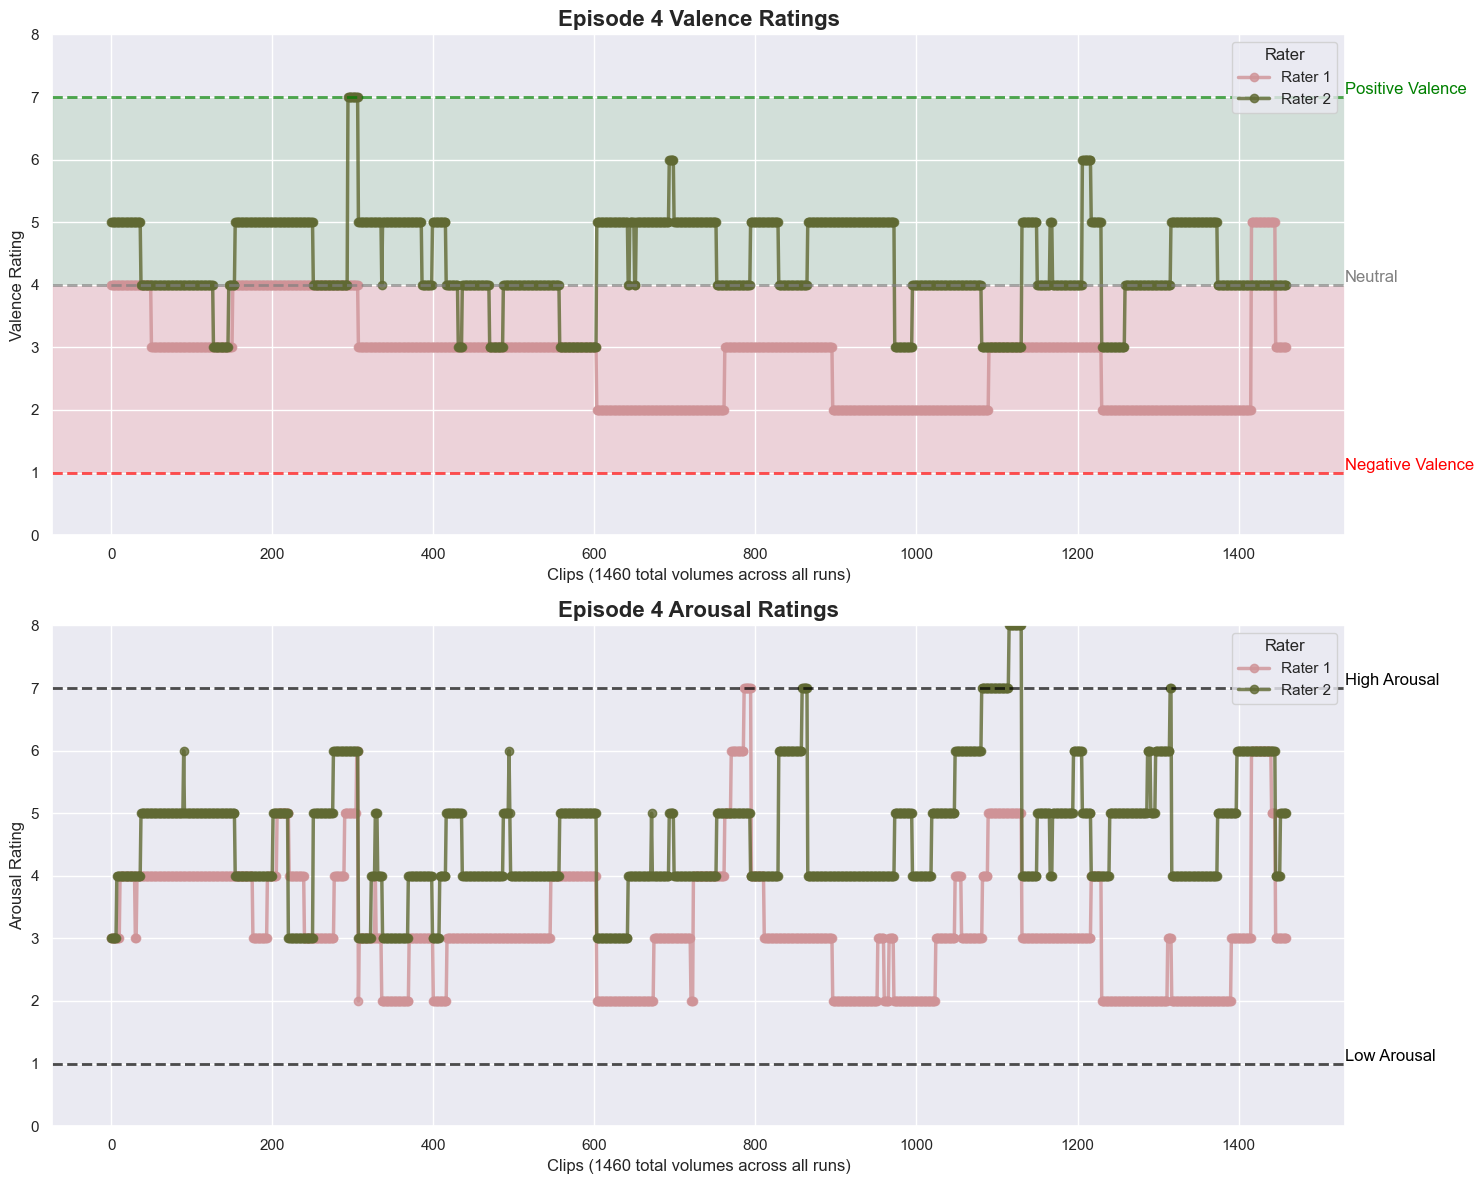

Sequential position range: 0 - 1459
Total clips: 1460
Number of runs: 5

All episode plots completed!


In [3]:
import re
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define colors for consistent plotting
colors = ['#CF9397', "#606933", '#E5D28E', '#715958', '#AC9B74', '#8c564b', '#e377c2', '#BCB5BB']

# Find all episode CSV files
episode_numbers = [1,2,3,4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem  # e.g., "S01E01"
    print(f"\n{'='*60}")
    print(f"Processing {episode_name}")
    print(f"{'='*60}")
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

    # Extract clip number from 'index' like S01E01R01_clip0007 -> 7
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)

    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    
    # Extract run number (e.g., "S01E01R01" -> 1)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    
    # Create sequential position: run order first, then clip order within run
    episode_df = episode_df.sort_values(['run_number', 'clip_number'])
    episode_df['sequential_position'] = range(len(episode_df))

    # ---- Make LONG data with rater column ----
    # Valence: columns valence_1, valence_2 -> rows with rater=1/2
    valence_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=val_cols,
        var_name='rater',
        value_name='valence'
    )
    valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # Arousal: columns arousal_1, arousal_2 -> rows with rater=1/2
    arousal_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=aro_cols,
        var_name='rater',
        value_name='arousal'
    )
    arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # ---- Plot ----
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    total_trs = len(episode_df)

    # Valence plot
    if not valence_long.empty:
        ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
        ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)

        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(valence_long['rater'].unique())):
            rater_data = valence_long[valence_long['rater'] == rater].sort_values('sequential_position')
            ax1.plot(rater_data['sequential_position'], rater_data['valence'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax1.set_title(f'Episode {ep_num} Valence Ratings', fontsize=16, fontweight='bold')
        ax1.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax1.set_ylabel('Valence Rating', fontsize=12)
        ax1.set_ylim(0, 8)
        ax1.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax1.get_xlim()[1]
        ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=12, color='red')
        ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=12, color='gray')
        ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=12, color='green')
    else:
        ax1.set_title('No valence columns found')

    # Arousal plot
    if not arousal_long.empty:
        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(arousal_long['rater'].unique())):
            rater_data = arousal_long[arousal_long['rater'] == rater].sort_values('sequential_position')
            ax2.plot(rater_data['sequential_position'], rater_data['arousal'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax2.set_title(f'Episode {ep_num} Arousal Ratings', fontsize=16, fontweight='bold')
        ax2.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax2.set_ylabel('Arousal Rating', fontsize=12)
        ax2.set_ylim(0, 8)
        ax2.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
        ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax2.get_xlim()[1]
        ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=12, color='black')
        ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=12, color='black')
    else:
        ax2.set_title('No arousal columns found')

    plt.tight_layout()
    plt.show()

    print(f"Sequential position range: 0 - {len(episode_df)-1}")
    print(f"Total clips: {len(episode_df)}")
    print(f"Number of runs: {episode_df['run_number'].nunique()}")

print(f"\n{'='*60}")
print("All episode plots completed!")
print(f"{'='*60}")


Processing S01E01 - Additional Plot


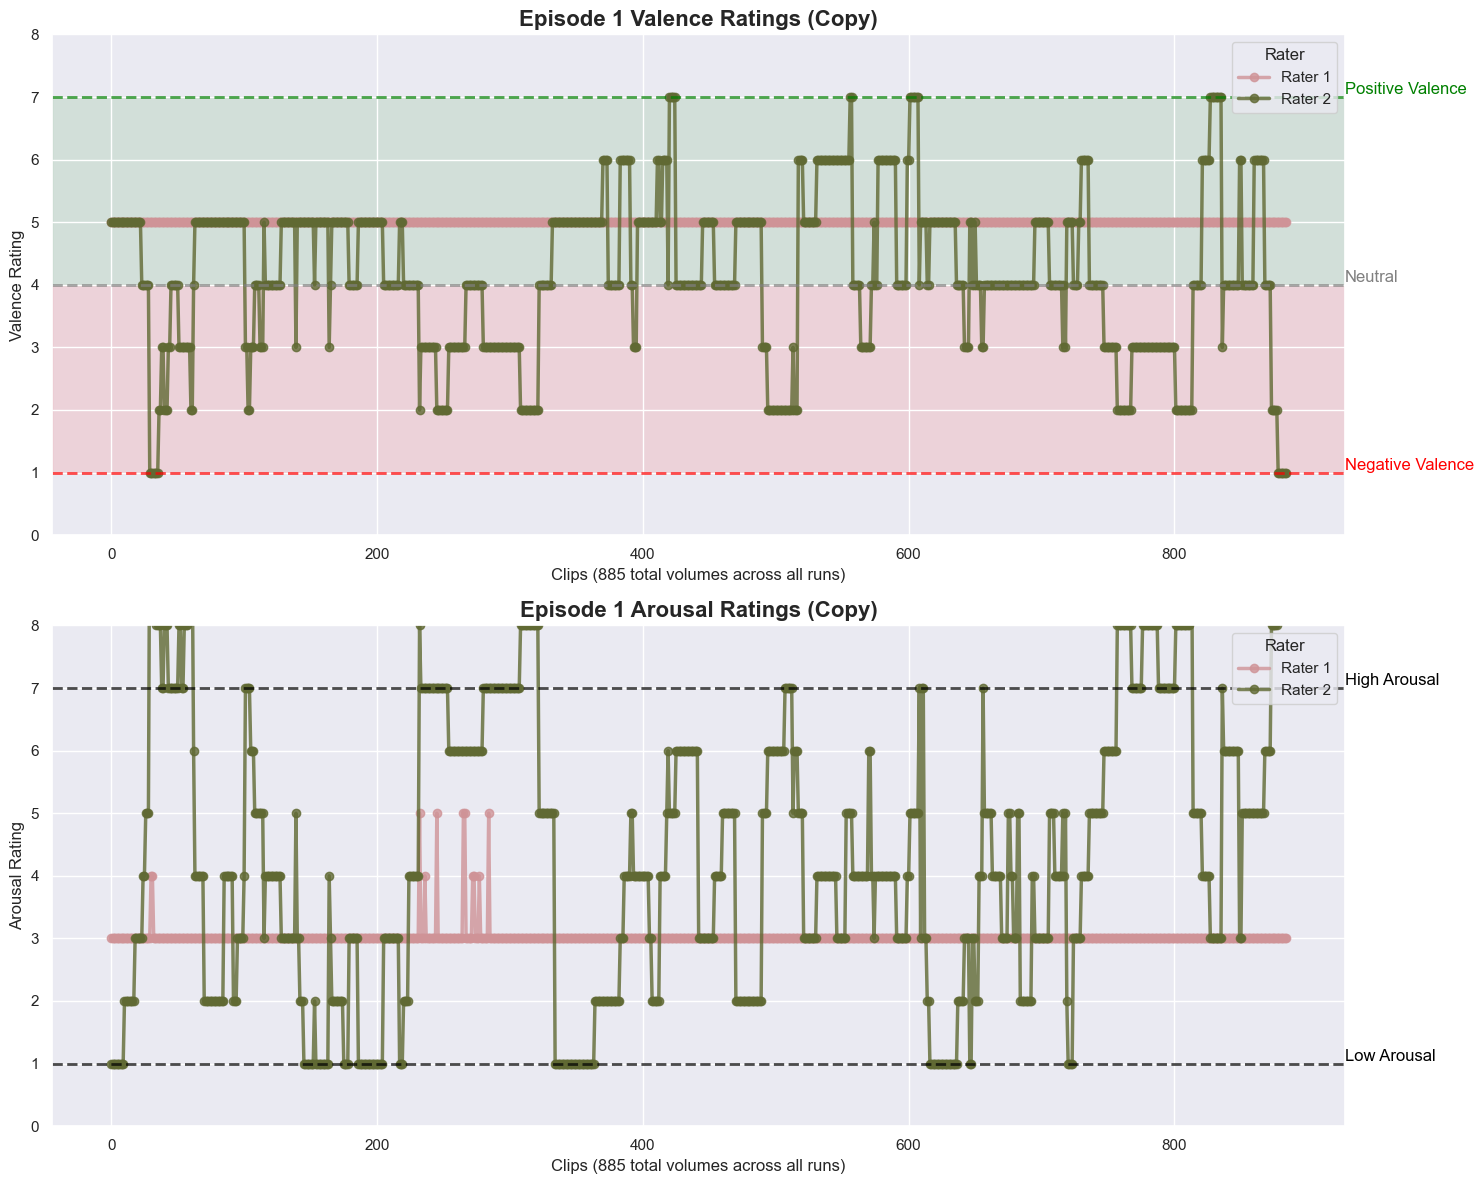

Sequential position range: 0 - 884
Total clips: 885
Number of runs: 3

Processing S01E02 - Additional Plot


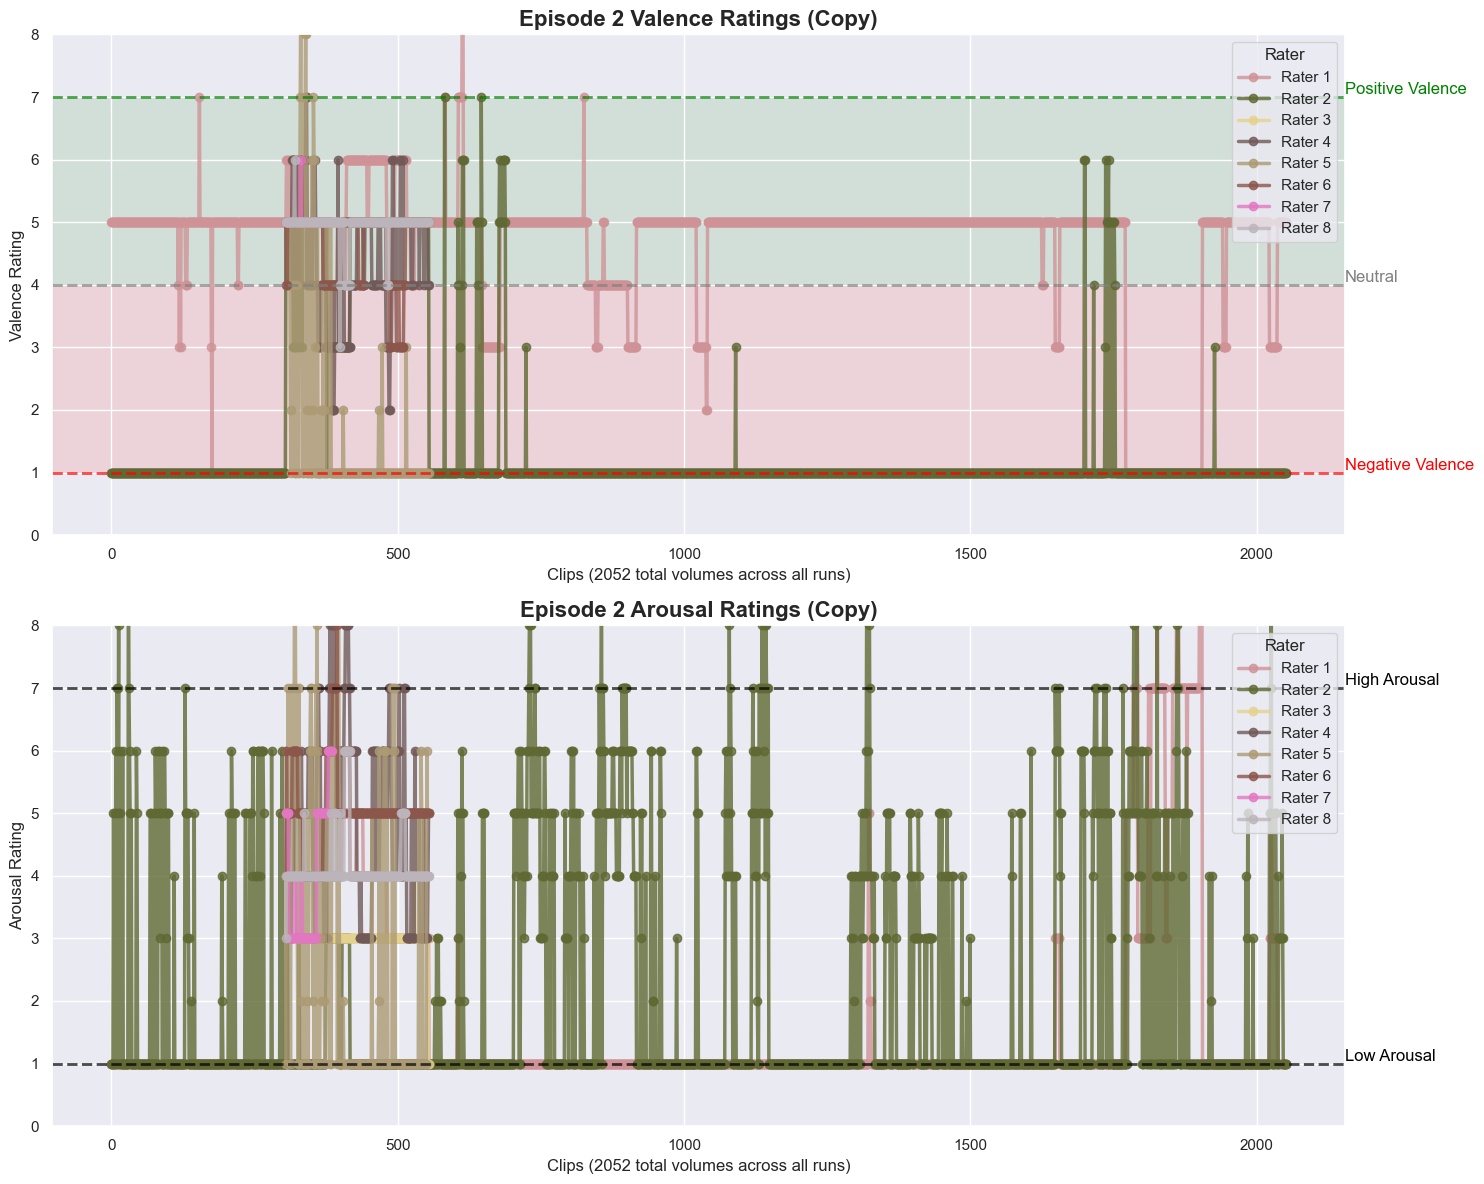

Sequential position range: 0 - 2051
Total clips: 2052
Number of runs: 7

Processing S01E03 - Additional Plot


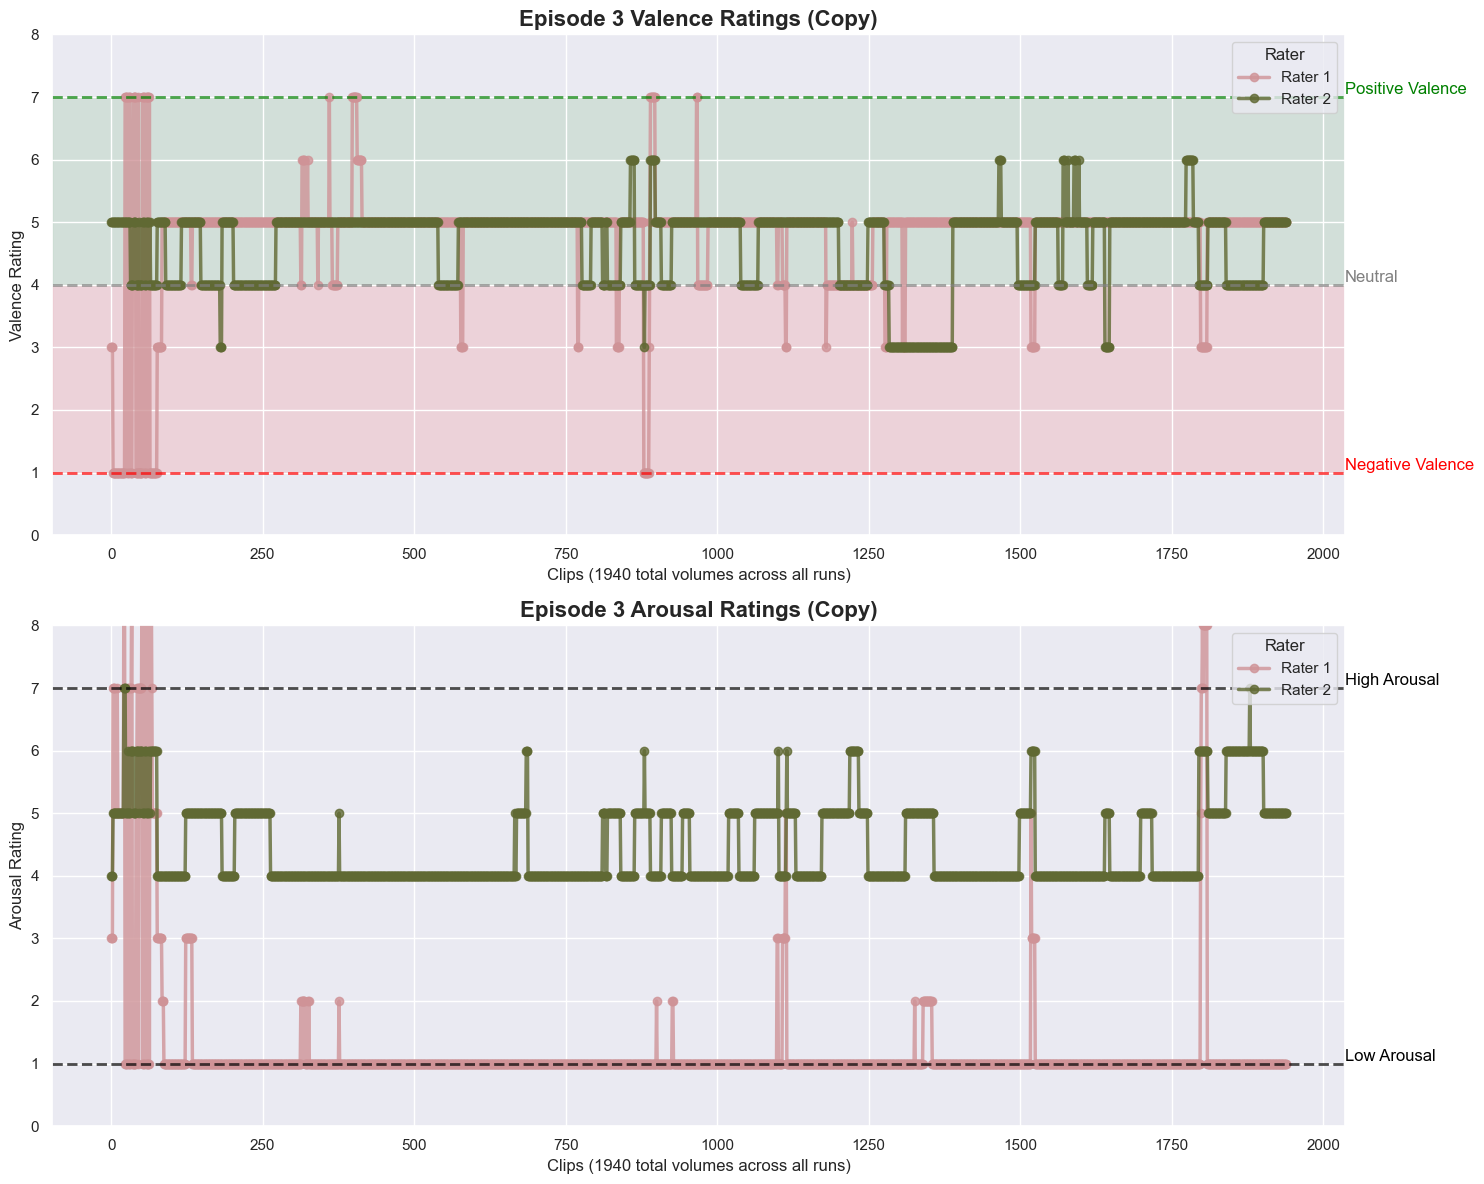

Sequential position range: 0 - 1939
Total clips: 1940
Number of runs: 6

Processing S01E04 - Additional Plot


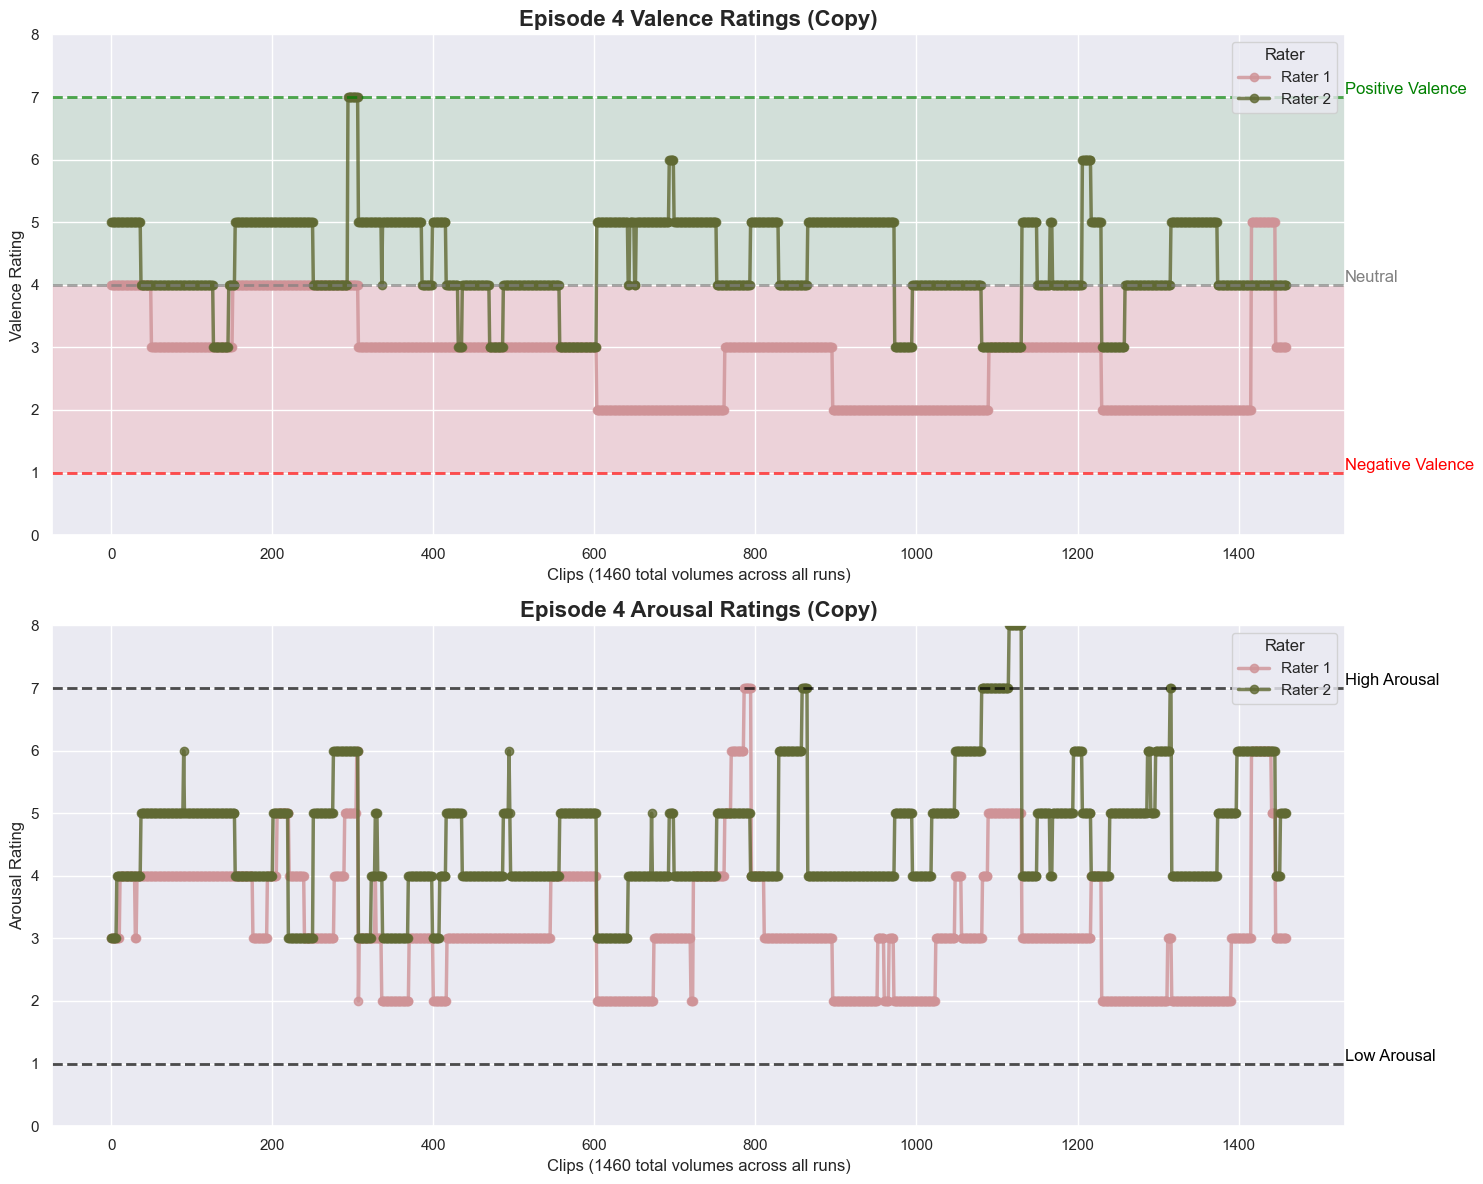

Sequential position range: 0 - 1459
Total clips: 1460
Number of runs: 5

All additional episode plots completed!


In [4]:
# Additional Episode Plotting - Same Style as Above
import re
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define colors for consistent plotting
colors = ['#CF9397', "#606933", '#E5D28E', '#715958', '#AC9B74', '#8c564b', '#e377c2', '#BCB5BB']

# Find all episode CSV files - plot each episode again
episode_numbers = [1,2,3,4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem  # e.g., "S01E01"
    print(f"\n{'='*60}")
    print(f"Processing {episode_name} - Additional Plot")
    print(f"{'='*60}")
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

    # Extract clip number from 'index' like S01E01R01_clip0007 -> 7
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)

    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    
    # Extract run number (e.g., "S01E01R01" -> 1)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    
    # Create sequential position: run order first, then clip order within run
    episode_df = episode_df.sort_values(['run_number', 'clip_number'])
    episode_df['sequential_position'] = range(len(episode_df))

    # ---- Make LONG data with rater column ----
    # Valence: columns valence_1, valence_2 -> rows with rater=1/2
    valence_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=val_cols,
        var_name='rater',
        value_name='valence'
    )
    valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # Arousal: columns arousal_1, arousal_2 -> rows with rater=1/2
    arousal_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=aro_cols,
        var_name='rater',
        value_name='arousal'
    )
    arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # ---- Plot ----
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    total_trs = len(episode_df)

    # Valence plot
    if not valence_long.empty:
        ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
        ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)

        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(valence_long['rater'].unique())):
            rater_data = valence_long[valence_long['rater'] == rater].sort_values('sequential_position')
            ax1.plot(rater_data['sequential_position'], rater_data['valence'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax1.set_title(f'Episode {ep_num} Valence Ratings (Copy)', fontsize=16, fontweight='bold')
        ax1.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax1.set_ylabel('Valence Rating', fontsize=12)
        ax1.set_ylim(0, 8)
        ax1.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax1.get_xlim()[1]
        ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=12, color='red')
        ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=12, color='gray')
        ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=12, color='green')
    else:
        ax1.set_title('No valence columns found')

    # Arousal plot
    if not arousal_long.empty:
        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(arousal_long['rater'].unique())):
            rater_data = arousal_long[arousal_long['rater'] == rater].sort_values('sequential_position')
            ax2.plot(rater_data['sequential_position'], rater_data['arousal'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax2.set_title(f'Episode {ep_num} Arousal Ratings (Copy)', fontsize=16, fontweight='bold')
        ax2.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax2.set_ylabel('Arousal Rating', fontsize=12)
        ax2.set_ylim(0, 8)
        ax2.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
        ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax2.get_xlim()[1]
        ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=12, color='black')
        ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=12, color='black')
    else:
        ax2.set_title('No arousal columns found')

    plt.tight_layout()
    plt.show()

    print(f"Sequential position range: 0 - {len(episode_df)-1}")
    print(f"Total clips: {len(episode_df)}")
    print(f"Number of runs: {episode_df['run_number'].nunique()}")

print(f"\n{'='*60}")
print("All additional episode plots completed!")
print(f"{'='*60}")